# 说明：
  
该实验自己完成的部分在Tutorial 11，英文注释部分为直接复制而来检测运行情况的部分  
问题：CUDA out of memory

# 图片风格迁移
  
使用三张图片，一张输入图片，一张内容图片和一张风格图片，将输入的图片变得与内容图片相似，且拥有风格图片的风格。  
  
定义两个间距，一个用于内容D_C，另一个用于风格D_S。D_C测量两张图片内容的不同，D_S测量两张图片风格的不同。输入第三张图片，并改变这张图片，使其与内容图片的内容间距和风格图片的风格间距最小化。  
  

## Preparation

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

%matplotlib inline

In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Load the picture

导入风格和内容图片。原始的PIL图片的值介于0到255之间，当转换成torch张量时，它们的值被转换成0到1之间。图片也需要被重设成相同的维度。  
torch库中的神经网络用来训练的张量的值为0到1之间。如果尝试将0到255的张量图片加载到神经网络，激活的特征映射将不能侦测到目标内容和风格。然而，Caffe库中的预训练网络用来训练的张量值为0到255之间的图片。


In [17]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/images/neural-style/picasso.jpg")
content_img = image_loader("./data/images/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

## 展示图片
  
通过重新将图片转换成PIL格式来展示，并使用plt.imshow展示它的拷贝。展示内容和风格图片来确保它们被正确的导入。

In [18]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

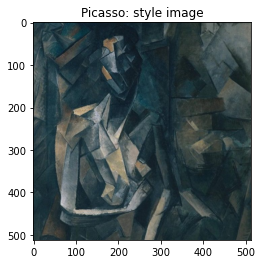

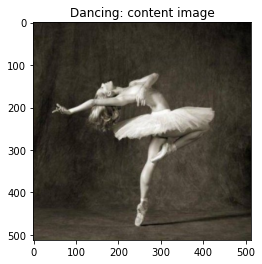

In [19]:
unloader = transforms.ToPILImage() # reconvert into PIL image
plt.ion()

def imshow(tensor, title = None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

plt.figure()
imshow(style_img, title='Picasso: style image')

plt.figure() 
imshow(content_img, title='Dancing: content image')

### 附加：直接展示

In [20]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

def imshow(name, title = None):
    image = mpimg.imread('./data/image/neural-style/'+name)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

plt.figure()
imshow('dancing.jpg')
imshow('picasso.jpg')

FileNotFoundError: [Errno 2] No such file or directory: './data/image/neural-style/dancing.jpg'

<Figure size 432x288 with 0 Axes>

## 损失函数

### 1. 内容损失

直接添加这个内容损失模型到被用来计算内容间距的卷积层之后。这样每一次输入图片到网络中时，内容损失都会在目标层被计算。而且因为自动求导，所有的梯度都会被计算。为了使内容损失层透明化，我们必须定义一个forward方法来计算内容损失，同时返回该层的输入。计算的损失作为模型的参数被保存。   
  
> **重要细节** ：尽管这个模型的名称被命名为 ContentLoss, 它不是一个真实的PyTorch损失方法。如果想要定义你的内容损失为PyTorch Loss方法，必须创建一个PyTorch自动求导方法来手动的在backward方法中重计算/实现梯度.

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### 2. 风格损失

为了计算风格损失，我们需要计算Gram矩阵。Gram矩阵是将给定矩阵和它的转置矩阵的乘积。最后，Gram矩阵必须通过将每一个元素除以矩阵中所有元素的数量进行标准化。标准化是为了消除拥有很大的N维度在Gram矩阵中产生的很大的值。这些很大的值将在梯度下降的时候，对第一层(在池化层之前)产生很大的影响。风格特征往往在网络中更深的层，所以标准化步骤是很重要的。 
  

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 导入模型
  
导入预训练的神经网络(19层的VGG网络)。   
PyTorch的VGG模型的实现被分为了两个Sequential模型：features(包含卷积层和池化层)和classifier(包含全连接层)。我们将使用features模型，因为我们需要每一层卷积层的输出来计算内容和风格损失。在训练的时候有些层会有和评估不一样的行为，所以我们必须用 .eval()将网络设置成评估模式。 

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

一个 Sequential 模型包含一个顺序排列的子模型序列。例如，vff19.features包含一个以正确的 深度顺序排列的序列<font color=grey face="mathfrak">（Conv2d, ReLU,MaxPool2d, Conv2d, ReLU…）</font> 。需要将自己的内容损失和风格损失层在感知到卷积层之后立即添加进去。因此必须创建一个新的Sequential模型，正确的插入内容损失和风格损失模型。 

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

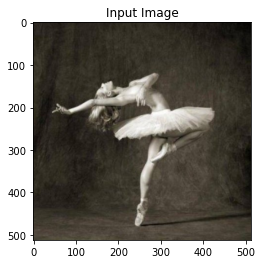

In [12]:
# 选择输入图片
input_img = content_img.clone()
# 如果您想使用白噪声而取消注释以下行： 
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title = 'Input Image')

## 梯度下降
  
使用 L-BFGS 算法来进行梯度下降。与训练一般网络不同，训练输入图片是为了最小化内容/风格损失。  
我们要创建一个 PyTorch 的 L-BFGS 优化器 optim.LBFGS，并传入图片到其中，作为张量去优化。 

In [13]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


定义一个方法来展示图像风格转换。对于每一次的网络迭代，都将更新过的输入传入其中并计算损失。要运行每一个损失模型的**backward**方法来计算它们的梯度。优化器需要一个“关闭”方法，它重新估计模型并且返回损失。  
最后一个问题: 神经网络可能会尝试使张量图片的值超过0到1之间来优化输入。可以通过在每次网络运行的时候将输入的值矫正到0到1之间来解决这个问题。 

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=100,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## 运行

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\朱子仪/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


E:\Anaconda\envs\Bling\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
E:\Anaconda\envs\Bling\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 4.178611 Content Loss: 4.237928



RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 2.00 GiB total capacity; 1.06 GiB already allocated; 31.00 MiB free; 1.15 GiB reserved in total by PyTorch)
Exception raised from malloc at ..\c10\cuda\CUDACachingAllocator.cpp:272 (most recent call first):
00007FFA29DD75A200007FFA29DD7540 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FFA29D79BB600007FFA29D79B40 c10_cuda.dll!c10::CUDAOutOfMemoryError::CUDAOutOfMemoryError [<unknown file> @ <unknown line number>]
00007FFA29D8064600007FFA29D7F320 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFA29D807EA00007FFA29D7F320 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFA29D7504900007FFA29D74E60 c10_cuda.dll!c10::cuda::CUDAStream::unpack [<unknown file> @ <unknown line number>]
00007FF9D17B1FE100007FF9D17B1EA0 torch_cuda.dll!at::native::empty_cuda [<unknown file> @ <unknown line number>]
00007FF9D18C8E5E00007FF9D186E400 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9D18C460500007FF9D186E400 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9C98C1A3A00007FF9C98AD9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FF9C98C000500007FF9C98AD9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FF9C99918A000007FF9C9988FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9C99A28DC00007FF9C99A2850 torch_cpu.dll!at::empty [<unknown file> @ <unknown line number>]
00007FF9C976F32400007FF9C976EFB0 torch_cpu.dll!at::TensorIterator::fast_set_up [<unknown file> @ <unknown line number>]
00007FF9C976D1C400007FF9C976D140 torch_cpu.dll!at::TensorIterator::build [<unknown file> @ <unknown line number>]
00007FF9C976C25D00007FF9C976C1A0 torch_cpu.dll!at::TensorIterator::TensorIterator [<unknown file> @ <unknown line number>]
00007FF9C976D0C600007FF9C976D000 torch_cpu.dll!at::TensorIterator::binary_op [<unknown file> @ <unknown line number>]
00007FF9C95D25F400007FF9C95D25A0 torch_cpu.dll!at::native::add [<unknown file> @ <unknown line number>]
00007FF9D18B61ED00007FF9D186E400 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9D18C293400007FF9D186E400 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9C998EB3F00007FF9C9988FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9C997F81A00007FF9C997F7A0 torch_cpu.dll!at::add [<unknown file> @ <unknown line number>]
00007FF9CACBF06E00007FF9CAC2E010 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FF9C9521A1400007FF9C9516470 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FF9C998EB3F00007FF9C9988FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9C9A8D3CA00007FF9C9A8D350 torch_cpu.dll!at::Tensor::add [<unknown file> @ <unknown line number>]
00007FF9CB0DAB3200007FF9CB0D9EF0 torch_cpu.dll!torch::autograd::wrap_outputs [<unknown file> @ <unknown line number>]
00007FF9CB0DB0C900007FF9CB0D9EF0 torch_cpu.dll!torch::autograd::wrap_outputs [<unknown file> @ <unknown line number>]
00007FF9CB0D0D0700007FF9CB0CFFD0 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FF9CB0D4FE200007FF9CB0D4CA0 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FF9CB0D4C4100007FF9CB0D4BC0 torch_cpu.dll!torch::autograd::Engine::thread_init [<unknown file> @ <unknown line number>]
00007FFA13E10A2700007FFA13DEA100 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FF9CB0CBF1400007FF9CB0CB780 torch_cpu.dll!torch::autograd::Engine::get_base_engine [<unknown file> @ <unknown line number>]
00007FFA51B50E8200007FFA51B50D40 ucrtbase.dll!beginthreadex [<unknown file> @ <unknown line number>]
00007FFA52B27BD400007FFA52B27BC0 KERNEL32.DLL!BaseThreadInitThunk [<unknown file> @ <unknown line number>]
00007FFA54ACCE5100007FFA54ACCE30 ntdll.dll!RtlUserThreadStart [<unknown file> @ <unknown line number>]


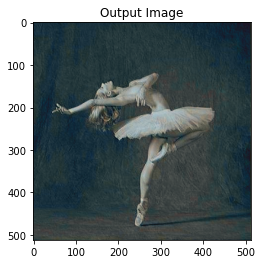

In [21]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4 
plt.ioff()
plt.show()